# Inference of parameters (SEIR model)
In this notebook, we consider the SEIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 
* $\gamma_{E}$ (rate from exposed to infected)

when given the full data (of classes S, E, Ia, Is) from a generated trajectory.

In [10]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [11]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [12]:
M  = 2              # the population has two age groups
N  = 5e4            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = 0.2         # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([10, 10])  # each age group has exposed individuals,
Ia0 = np.array([10, 10])  # and asymptomatic infectives,
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 160
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

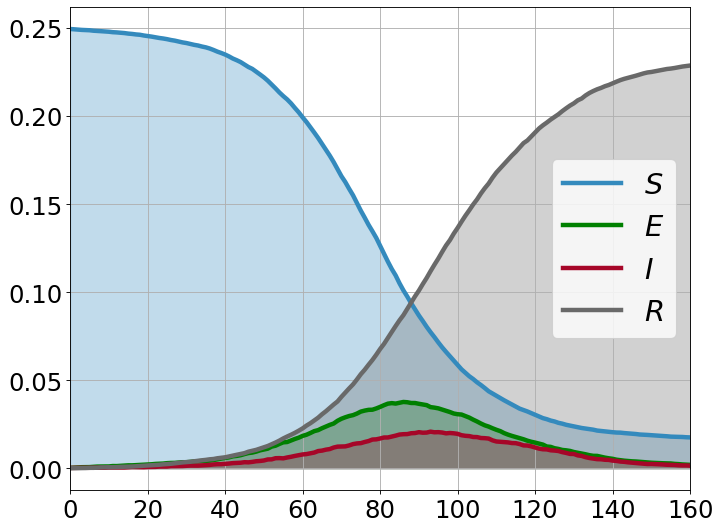

In [13]:
# plot the data and obtain the epidemic curve for one age group 
S  = data['X'][:,0]
E  = data['X'][:,2]
Ia = data['X'][:,4]
Is = data['X'][:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $50$ data points of the trajectories and use it to infer the parameters of the model.

In [14]:
Tf = 50 # truncate to only getting the first few datapoints 
Nf = Tf+1

# load the data and rescale to intensive variables 
x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101  # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-3331.703254468493
0.3595700263977051


In [15]:
# take a guess 
beta_g    = 0.05
beta_std  = 0.03
gIa_g     = 0.2
gIa_std   = 0.1
gIs_g     = 0.2
gIs_std   = 0.1
alpha_g   = 0.2
alpha_std = 0.1
gE_g      = 0.02 
gE_std    = 0.01

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'gE':gE_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

-497.19251637977743


In [16]:
# inference  
eps = 1e-4   # step size for finite difference computation of Hessian
ftol = 1e-6  # Stopping criterion for minimisation (realtive change in function value)

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g])
stds  = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std])
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6), (eps, 0.6)])  # give some bounds

start_time = time.time() 
params = estimator.inference(guess, stds, x, Tf, Nf, contactMatrix, bounds=bounds, global_max_iter=25,
                             eps=eps, global_ftol_factor=1e3, ftol=ftol, verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 5 (seed=944640, Thu May  7 11:11:25 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.731124239100788e+03 1.0e+00 1.11e+00  1e-02  1e-01 0:05.5
    2     32 -2.112117625151956e+03 1.4e+00 1.33e+00  2e-02  1e-01 0:11.0
    3     48 -2.910222143595071e+03 1.8e+00 1.53e+00  2e-02  2e-01 0:17.6
    4     64 -3.145056828658206e+03 2.6e+00 1.56e+00  3e-02  2e-01 0:24.1
    5     80 -2.497874647292902e+03 3.2e+00 1.74e+00  3e-02  2e-01 0:29.5
    6     96 -2.838844281161460e+03 3.7e+00 1.61e+00  2e-02  2e-01 0:35.2
    8    128 -3.083963128710714e+03 5.1e+00 1.19e+00  1e-02  1e-01 0:46.4
   10    160 -3.118965539767758e+03 5.2e+00 9.94e-01  7e-03  1e-01 0:55.3
   12    192 -3.220554225503329e+03 6.3e+00 7.97e-01  5e-03  7e-02 1:03.5
   15    240 -3.294525880408208e+03 7.0e+00 8.35e-01  5e-03  6e-02 1:17.0
   18    288 -3.299824220495604e+03 1.1e+01 1.18e+00  5e-03  1e-0

In [17]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3], 'gE':params[4], 'fsa':fsa}
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-3333.0264233758844
0.33013081550598145


In [18]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 0.8}

Inferred parameters:
{'alpha': 0.20473981225555404, 'beta': 0.0196305123004103, 'gIa': 0.15235440379541448, 'gIs': 0.14159341141205498, 'gE': 0.09517392643018575, 'fsa': 0.8}
